In [1]:
import pandas as pd


df = pd.read_csv('data.csv')

print(df.columns)

df.head()

Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


## Preprocess

In [2]:
cols_to_keep = ['Make', 'Model', 'Year', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Vehicle Style',
       'highway MPG', 'city mpg', 'MSRP']

df = df[cols_to_keep]

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [4]:
df.fillna(0, inplace=True)

In [5]:
# Make price binary

average_price =  df['msrp'].mean()

df['above_average'] = (df['msrp'] > average_price).astype(int)

df.head()


,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


## Split the data

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into 80% "train + validation" and 20% test
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Split the "train + validation" data into 75% train and 25% validation
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=1)

print("Train:", len(df_train))
print("Validation:", len(df_val))
print("Test:", len(df_test))


Train: 7148
Validation: 2383
Test: 2383


### 1. Question 1: ROC AUC feature importance

In [7]:
from sklearn.metrics import roc_auc_score

# List of numerical variables to evaluate
numerical_vars = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]

# Dictionary to store the AUC for each variable
auc_scores = {}

# Loop through each variable and compute AUC
for var in numerical_vars:
    auc = roc_auc_score(df_train['above_average'], df_train[var])
    
    # If AUC is below 0.5, negate the variable and compute AUC again
    if auc < 0.5:
        auc = roc_auc_score(df_train['above_average'], -df_train[var])
    
    # Store the AUC in the dictionary
    auc_scores[var] = auc

# Determine which variable has the highest AUC
max_var = max(auc_scores, key=auc_scores.get)

print(auc_scores)
print(f"The variable with the highest AUC is: {max_var}")


{'engine_hp': 0.9171031265539011, 'engine_cylinders': 0.766116490165669, 'highway_mpg': 0.6330587871772013, 'city_mpg': 0.6734244643245233}
The variable with the highest AUC is: engine_hp


### 2. Training the Model

In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# 1. Prepare the data with" one-hot encoding
train_dicts = df_train.drop(columns=['above_average', 'msrp']).to_dict(orient='records')
val_dicts = df_val.drop(columns=['above_average', 'msrp']).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# 2. Train a logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, df_train['above_average'])

# 3. Evaluate the model's AUC on the validation dataset
y_pred_val = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(df_val['above_average'], y_pred_val)

print(round(auc, 3))


0.977


### 3. Recall and Precision

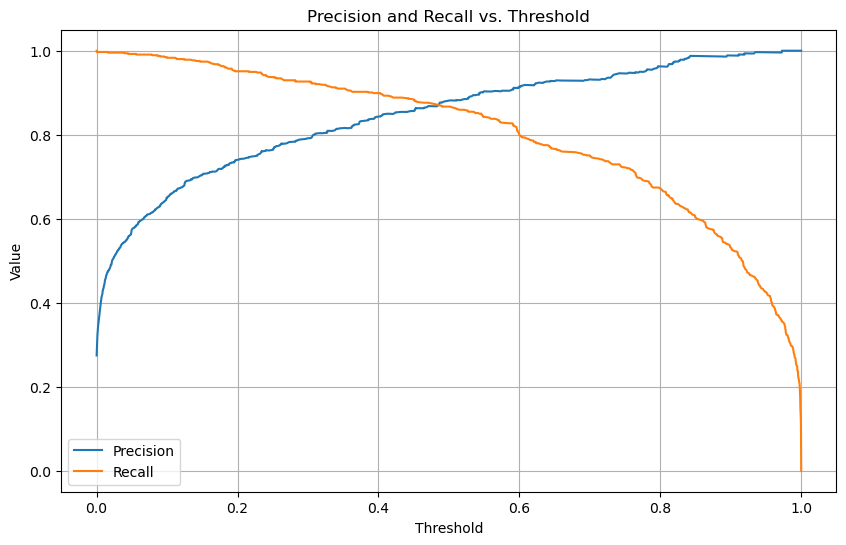

Precision and Recall intersect at threshold: 0.49


In [10]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(df_val['above_average'], y_pred_val)
thresholds = np.append(thresholds, 1)  # append 1 at the end to align with precision and recall

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Identify threshold where precision and recall intersect
intersect_threshold = thresholds[np.argmin(np.abs(precision - recall))]
print(f"Precision and Recall intersect at threshold: {intersect_threshold:.2f}")


### 4. F1

Maximum F1 is achieved at threshold: 0.55


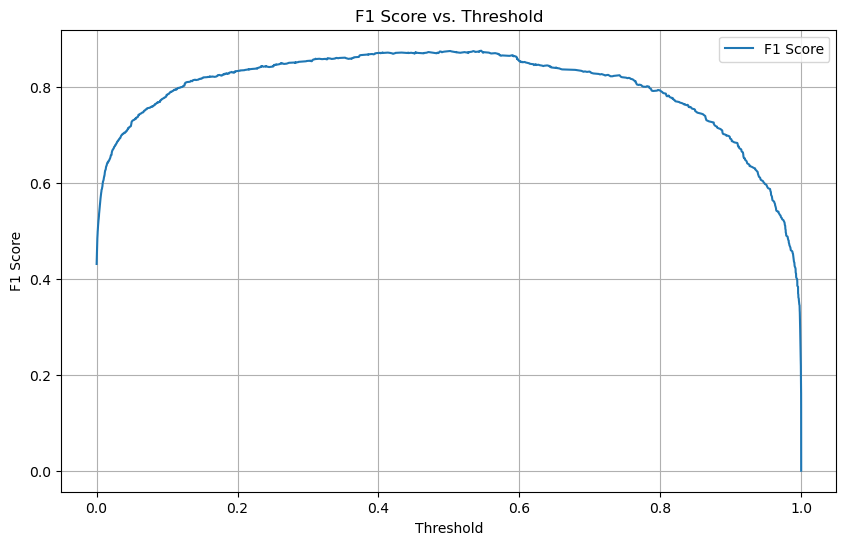

In [11]:
# Compute F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find threshold where F1 is maximal
max_f1_threshold = thresholds[np.argmax(f1_scores)]

print(f"Maximum F1 is achieved at threshold: {max_f1_threshold:.2f}")

# Optionally, plot F1 scores across thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()


### 5. K-fold CV

In [13]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer


# Combine train and validation datasets to form df_full_train
df_full_train = pd.concat([df_train, df_val])

# Set up the KFold split
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Prepare the full data with one-hot encoding
full_train_dicts = df_full_train.drop(columns=['above_average', 'msrp']).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)
y_full_train = df_full_train['above_average']

scores = []

# Iterate over the train and validation indices provided by the KFold split
for train_idx, val_idx in kf.split(X_full_train):
    # Split the data into train and validation
    X_train_fold, X_val_fold = X_full_train[train_idx], X_full_train[val_idx]
    y_train_fold, y_val_fold = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    
    # Evaluate the model on validation and get the AUC
    y_pred = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred)
    
    scores.append(auc)

# Calculate the standard deviation of the scores
std_dev = np.std(scores)

print(f"Standard Deviation of AUC scores across folds: {std_dev:.3f}")


Standard Deviation of AUC scores across folds: 0.002


### 6. Hyperparameter Tuning

In [14]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Define the C values to iterate over
C_values = [0.01, 0.1, 0.5, 10]
mean_scores = []
std_scores = []

# Prepare the full data with one-hot encoding
full_train_dicts = df_full_train.drop(columns=['above_average', 'msrp']).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)
y_full_train = df_full_train['above_average']

# Iterate over C values
for C in C_values:
    scores = []
    for train_idx, val_idx in kf.split(X_full_train):
        # Split data into train and validation for the current fold
        X_train_fold, X_val_fold = X_full_train[train_idx], X_full_train[val_idx]
        y_train_fold, y_val_fold = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]

        # Initialize and train the model with the current C value
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)

        # Predict probabilities and compute AUC for the current fold
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred)
        scores.append(auc)

    # Compute mean and std AUC for the current C value
    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

# Identify the C value that yields the best mean AUC score
max_mean_score = max(mean_scores)
corresponding_std = std_scores[mean_scores.index(max_mean_score)]
corresponding_C = C_values[mean_scores.index(max_mean_score)]

print(f"Best C value: {corresponding_C}")
print(f"Mean AUC score: {round(max_mean_score, 3)}")
print(f"Standard deviation: {round(corresponding_std, 3)}")


Best C value: 10
Mean AUC score: 0.983
Standard deviation: 0.003
